In [2]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from venn import venn
from collections import defaultdict
import itertools
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from adjustText import adjust_text

In [17]:
## Read the absrel final table: branch \t p-value \t transcript \t gene
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v8_results/'
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v58_results/'
# dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/v58_srv_results/'
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/combined_default_srv_mh/'

# file_name = 'validated.all.genes.pval.table.tsv'
# file_name = 'all.genes.pval.table.tsv'
file_name = 'combined.all.genes.pval.table.v58.tsv'

file_data = glob(dir_path + file_name)[0]
pval_tab = pd.read_csv(file_data, sep='\t')

## filter all unknown genes: reg_* - don't do this!
# pval_tab = pval_tab[~pval_tab['gene'].str.startswith('reg_')]

pval_tab.head()

,branch,pval,trans,gene
0,HLacaPus1,1.0,SLC41A2_rna-XM_015286032.2,SLC41A2
1,HLacaPus1_HLparPun1,1.0,SLC41A2_rna-XM_015286032.2,SLC41A2
2,HLamaAes1,1.0,SLC41A2_rna-XM_015286032.2,SLC41A2
3,HLamaAes1_HLaraSol1,1.0,SLC41A2_rna-XM_015286032.2,SLC41A2
4,HLamaAes1_HLnymHol2,1.0,SLC41A2_rna-XM_015286032.2,SLC41A2


In [18]:
## Read all bracnhes from tree
# dir_path = '/Users/osipova/Documents/LabDocs/Birds_Phylogeny/'
# file_name = '45_bird_code_tree_topology.ans.tree'

# with open(dir_path + file_name, 'r') as inf:
#     all_branches = inf.read().rstrip().replace('(', '').replace(')', ',').split(',')

In [19]:
## Define groups of species: Nectar project
# core nectar groups
hmmbrds = ["HLcalAnn5", "HLfloFus1", "HLphaSup1", "HLfloFus1_HLcalAnn5", "HLfloFus1_HLphaSup1"]
honeyeaters = ["HLlicMelCas1", "HLphyNov1", "HLgraPic1", "HLlicPen1",
             "HLlicMelCas1_HLgraPic1", "HLlicMelCas1_HLlicPen1", "HLlicMelCas1_HLphyNov1"]
# sunbirds = ["HLcinPul1", "HLlepAsp1", "HLlepAsp1_HLcinPul1", "HLdicExi1", "HLlepAsp1_HLdicExi1"]
sunbirds = ["HLlepAsp1", "HLdicExi1", "HLlepAsp1_HLdicExi1"]
nectar_parrots = ["HLtriMol2", "HLlorGal1", "HLamaAes1", "HLaraSol1",
          "HLamaAes1_HLaraSol1", "HLtriMol2_HLlorGal1", "HLamaAes1_HLtriMol2"]

# core nonnectar groups
swifts = ['HLapuApu1', 'HLchaPel1', 'HLchaPel1_HLapuApu1']
falcons = ['falPer1', 'falChe1', 'HLfalTin1', 'falPer1_falChe1', 'falPer1_HLfalTin1']
lyrebirds = ['HLatrCla1', 'HLmenNov1', 'HLatrCla1_HLmenNov1']
passerides = ['HLtaeGut4', 'pseHum1', 'ficAlb2', 'HLmelMel1_ficAlb2', 'HLparMaj1_pseHum1', 
              'HLmelMel1_HLparMaj1', 'HLmelMel1_HLtaeGut4', 'HLmelMel1_HLlepAsp1']

# ambiguous groups
songbirds = ["HLacaPus1", "HLacaPus1_HLparPun1", "HLlicMelCas1_HLacaPus1",
             "HLmalEle1", "HLmalCya1", "HLmalCya1_HLmalEle1", "HLcliRuf1"]
parrots_rest = ["HLnymHol2", "HLstrHab1", "HLamaAes1_HLnymHol2", "HLamaAes1_HLstrHab1"]
passerins = ["HLserCan1", "HLmelMel1", "HLmelMel1_HLserCan1", "HLparMaj1"]
flycatcher = ["HLempTra1"]
pardalote = ["HLparPun1"]

# nectar_br = hmmbrds + honeyeaters + pardalote + sunbirds + nectar_parrots
nectar_br = hmmbrds + honeyeaters + sunbirds + nectar_parrots
nonnectar = swifts + falcons + lyrebirds + passerides
ambiguous = parrots_rest + passerins + songbirds + flycatcher + pardalote

In [20]:
## Dict for genes

## Define p-value threshold:
# pval_thresh = 0.01
pval_thresh = 0.05

# Drop transc column; leave significant pvalues: <= threshold; group by gene
df = pval_tab.drop('trans', axis=1).loc[pval_tab['pval'] <= pval_thresh].groupby('gene')
gene_dict = dict(tuple(df))

In [21]:
## Make a dict: gene : percent of nectar takers under positive selection
 
def calc_target_ratio(target, target_clades):
    ## Takes target name and list of terget branches;
    ## Outputs a dict with gene: (ratio, branches under selection)
    
    ratio_target_dict = {}
    for g in gene_dict:
        count_target = 0
        count_out = 0
        for branch in list(gene_dict[g].branch):
            if branch in target_clades:
                count_target += 1
            if (branch not in target_clades ) and (branch not in ambiguous):
                count_out += 1
        if count_target != 0:
            ratio_target = count_target / (count_target + count_out)
            ratio_target_dict[g] = (ratio_target, set(gene_dict[g]['branch']))
    return(ratio_target_dict)

In [27]:
### Define target group (once!)
target = 'nonnectar'
# target = 'nectar'

if target == 'nectar':
    branches = nectar_br
elif target == 'nonnectar':
    branches = nonnectar

## get relevance reatio for target bracnches
ratio_target_dict = calc_target_ratio(target, branches)

/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/combined_default_srv_mh/0.05_ranked_genes_nonnectar_ratio.pdf


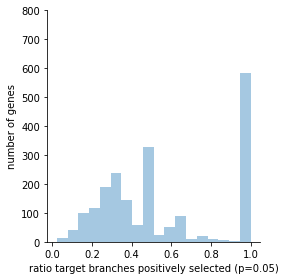

In [28]:

all_ratio_values = [v[0] for v in ratio_target_dict.values()]
fig, axes = plt.subplots(figsize=(4, 4))
sns.distplot(all_ratio_values, bins=18, kde=False)

axes.set_xlabel('ratio target branches positively selected (p={})'.format(pval_thresh))
axes.set_ylabel('number of genes')
axes.set_ylim(0, 800)

sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = "{}{}_ranked_genes_{}_ratio.pdf".format(dir_path, pval_thresh, target)
print(pdf_name)
fig.savefig(pdf_name, bbox_inches='tight')


In [29]:
## Output genes in dictionary that have target ratio above the threshold
threshold = 0.5
# threshold = 0.99
count = 0

out_dir = dir_path
out_file_name = 'under_selection_ranked_genes_{}_{}.tsv'.format(threshold, target)
out_file = out_dir + out_file_name

filtered_genes = []
with open(out_file, 'w') as ouf:
    for k, v in ratio_target_dict.items():
#     for k, v in sorted(ratio_target_dict.items(), key=lambda item: item[1]):
        if (v[0] > threshold):
            count += 1
            filtered_genes.append(k)
            out_line = '{}\t{}\t{}\n'.format(k, v[0], ','.join(list(v[1])))
            ouf.write(out_line)
            #print('{}\t{}'.format(k, v))

print('Number of genes above the {} threshold is: {}'.format(threshold, count))

Number of genes above the 0.5 threshold is: 788


In [30]:
## Create filtered gene lists

if target == 'nectar':
    fg_list = [hmmbrds, honeyeaters, nectar_parrots, sunbirds]
    fg_names_list = ['hmmbrds', 'honeyeaters', 'nectar_parrots', 'sunbirds']

elif target == 'nonnectar':
    fg_list = [swifts, falcons, lyrebirds, passerides]
    fg_names_list = ['swifts', 'falcons', 'lyrebirds', 'passerides']

number_fg_in_clade = 1
per_clade_genes = defaultdict(list)

out_dir = dir_path
out_file_name = 'under_selection_per_clade_{}.{}.tsv'.format(pval_thresh, target)
out_file = out_dir + out_file_name

with open(out_file, 'w') as ouf:
    for i in range(len(fg_names_list)):
        fg = fg_list[i]
        fg_name = fg_names_list[i]
        for g in filtered_genes:
            branches = set(ratio_target_dict[g][1])
            if len(list(set(fg) & branches)) >= number_fg_in_clade:
                per_clade_genes[fg_name].append(g)
                ouf.write('{}\t{}\t{}\n'.format(fg_name, g, ','.join(ratio_target_dict[g][1])))

/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/combined_default_srv_mh/venn_genes_p_0.05_nonnectar_ratio_greater0.5.pdf


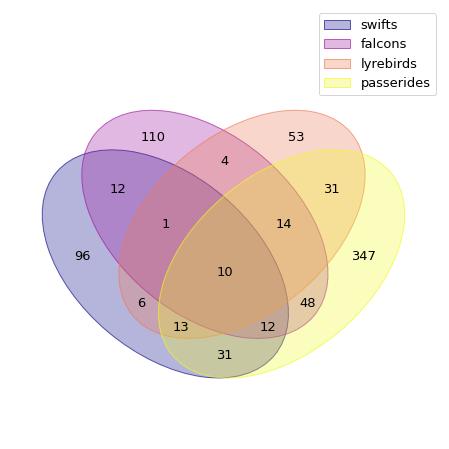

In [31]:
## Do Venns
# convert lists to sets
for k in per_clade_genes:
    per_clade_genes[k] = set(per_clade_genes[k])
venn(per_clade_genes, cmap='plasma', alpha=0.3)

pdf_name = "{}venn_genes_p_{}_{}_ratio_greater{}.pdf".format(dir_path, pval_thresh, target, threshold)
print(pdf_name)
# plt.savefig("{}fg_2branches.venn_genes_p_{}_nectar_ratio_{}.noReg.pdf".format(dir_path, pval_thresh, threshold))
# plt.savefig("{}venn_genes_p_{}_nectar_ratio_{}.noReg.pdf".format(dir_path, pval_thresh, threshold))
plt.savefig(pdf_name)

In [66]:
### Intentionally left blank

In [15]:
## Calculate degree of convergence

def calc_convergence_ratio(total, per_clade_genes, clades):
    ## Calculates ratio of Observed to Expected number of genes

    Ni = [len(per_clade_genes[c]) for c in clades]
    pi = [i / total for i in Ni]
    all_clades_list = [per_clade_genes[c] for c in clades]
    Nconv = len(set(all_clades_list[0]).intersection(*all_clades_list[1:]))
    R = Nconv / (np.prod(pi) * total)
    return R


In [68]:
total = len(filtered_genes)
R_target = []

for pair in itertools.combinations(fg_names_list, r=2):
    R = calc_convergence_ratio(total, per_clade_genes, pair)
    R_target.append([2, R])
    print('For pair {} degree of convergence is = {}'.format(pair, R))
    
for three in itertools.combinations(fg_names_list, r=3):
    R = calc_convergence_ratio(total, per_clade_genes, three)
    R_target.append([3, R])
    print('For clades {} degree of convergence is = {}'.format(three, R))
    
for four in itertools.combinations(fg_names_list, r=4):
    R = calc_convergence_ratio(total, per_clade_genes, four)
    R_target.append([4, R])
    print('For clades {} degree of convergence is = {}'.format(four, R))
    

For pair ('swifts', 'falcons') degree of convergence is = 0.6607894736842105
For pair ('swifts', 'lyrebirds') degree of convergence is = 0.873597929249353
For pair ('swifts', 'passerides') degree of convergence is = 0.5434355118565646
For pair ('falcons', 'lyrebirds') degree of convergence is = 0.8365573770491802
For pair ('falcons', 'passerides') degree of convergence is = 0.5767912087912088
For pair ('lyrebirds', 'passerides') degree of convergence is = 0.814231669969375
For clades ('swifts', 'falcons', 'lyrebirds') degree of convergence is = 1.1463352027610008
For clades ('swifts', 'falcons', 'passerides') degree of convergence is = 0.5805858877964142
For clades ('swifts', 'lyrebirds', 'passerides') degree of convergence is = 1.0077672112184626
For clades ('falcons', 'lyrebirds', 'passerides') degree of convergence is = 1.0531167357232931
For clades ('swifts', 'falcons', 'lyrebirds', 'passerides') degree of convergence is = 1.8366557424456476


In [69]:
# R_df_nectar = pd.DataFrame(R_target, columns=['way', 'ratio'])
R_df_nonnectar = pd.DataFrame(R_target, columns=['way', 'ratio'])

In [78]:
R_df_nectar['type'] = ['nectar'] * R_df_nectar.shape[0]
R_df_nonnectar['type'] = ['nonnectar'] * R_df_nonnectar.shape[0]

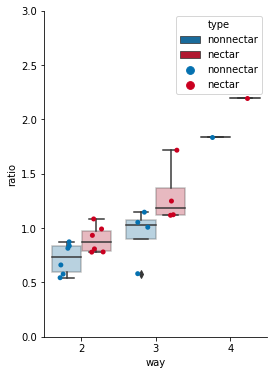

In [163]:
df = pd.concat((R_df_nectar, R_df_nonnectar), ignore_index=True)
# df['corr'] = np.where(df['type'] == 'nectar', 0.1, -0.05)
# df['way_corr'] = df['way'] + df['corr']

sns.set_palette(['#0571b0', '#ca0020'])
fig, axes = plt.subplots(figsize=(4, 6))
sns.stripplot(data=df, x='way', y='ratio', hue='type', hue_order=['nonnectar', 'nectar'],
              dodge=True, jitter=0.2)
sns.boxplot(data=df, x='way', y='ratio', hue='type', hue_order=['nonnectar', 'nectar'],
            boxprops=dict(alpha=.3))

axes.set_ylim(0, 3)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

plot_name = 'convergence_ratio.positive_selection.pdf'
# plt.savefig(plot_name)

In [159]:
nectar_2way = R_df_nectar[R_df_nectar['way'] == 2]['ratio']
nonnectar_2way = R_df_nonnectar[R_df_nonnectar['way'] == 2]['ratio']

nectar_3way = R_df_nectar[R_df_nectar['way'] == 3]['ratio']
nonnectar_3way = R_df_nonnectar[R_df_nonnectar['way'] == 3]['ratio']

print(mannwhitneyu(nectar_2way, nonnectar_2way, alternative='two-sided'))
print(mannwhitneyu(nectar_3way, nonnectar_3way, alternative='two-sided'))

MannwhitneyuResult(statistic=27.0, pvalue=0.1734854683214785)
MannwhitneyuResult(statistic=14.0, pvalue=0.11235119769046385)


In [ ]:
### Intentionally left blank

In [28]:
## Explore GO terms: response to radiation VS flu response: nectar VS nonnectar
ratio_target_dict_nectar = calc_target_ratio('nectar', nectar_br)
ratio_target_dict_nonnectar = calc_target_ratio('nonnectar', nonnectar)

## GO:0009314 response to radiation - get genes
# file_name = 'Metascape_enrich_4_lists/genes.GO_0009314.txt'
# file_name = 'Metascape_enrich_4_lists/genes.GO_0002819.txt'
file_name = 'Metascape_enrich_4_lists/genes.GO_0045321.txt'
file_data = glob(dir_path + file_name)[0]
go1_tab = pd.read_csv(file_data, sep='\t')
go1_genes = go1_tab['gene']

at_least_one_target_nectar = []
for g in ratio_target_dict_nectar:
    if ratio_target_dict_nectar[g][0] > 0:
        at_least_one_target_nectar.append(g)
        
at_least_one_target_nonnectar = []
for g in ratio_target_dict_nonnectar:
    if ratio_target_dict_nonnectar[g][0] > 0:
        at_least_one_target_nonnectar.append(g)
        
go1_genes_nectar = list(set(go1_genes) & set(at_least_one_target_nectar))
go1_genes_nonnectar = list(set(go1_genes) & set(at_least_one_target_nonnectar))

print(len(go1_genes_nectar))
print(len(go1_genes_nonnectar))
print(len(set(go1_genes_nectar) & set(go1_genes_nonnectar)))

93
85
48


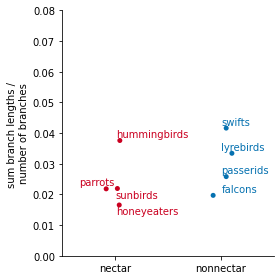

In [41]:
### Check total branch length per groups
BL_df = pd.DataFrame.from_dict({'group': ['hummingbirds',
                           'honeyeaters', 
                           'parrots',
                           'sunbirds',
                           'swifts', 
                           'lyrebirds',
                           'passerids',
                           'falcons'],
                 'branch_length': [0.18795759,
                               0.11596274, 
                               0.15354985, 
                               0.1091534, 
                               0.1248886,
                               0.1002603,
                               0.20651251,
                               0.09851877],
                'branch_number': [5, 7, 7, 5, 3, 3, 8, 5],
                'type': ['nectar']*4 + ['nonnectar']*4})

BL_df['norm_BL'] = BL_df['branch_length'] / BL_df['branch_number']

p = ['#ca0020', '#0571b0']
sns.set_palette(p)
fig, axes = plt.subplots(figsize=(4, 4))
sns.stripplot(data=BL_df, x='type', y='norm_BL', dodge=True, jitter=0.15)


axes.set_ylim(0, 0.08)
axes.set_xlabel('')
axes.set_ylabel('sum branch lengths / \nnumber of branches')
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)


labels = []
for x, y, l in zip(BL_df['type'], BL_df['norm_BL'], BL_df['group']):
    if x == 'nectar':
        x = 0
        c = p[0]
    elif x == 'nonnectar':
        x = 1
        c = p[1]
    labels.append(axes.text(x=x, y=y, s=l, color=c, size=10))
adjust_text(labels, ax=axes)

fig.tight_layout()
plot_name = 'total_branch_length_nectar_vs_nonnectar.pdf'
# plt.savefig(plot_name, bbox_inches='tight')

In [17]:
### Fisher-exact test for convergence
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2021/'
file_name = 'summary.matching_test_control.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

df['count'] = [len(i.split(',')) for i in df['pair']]
df.head(3)

,pair,type,value,count
0,"hmmbrds,honey",Odds Ratio,1.998588,2
1,"hmmbrds,honey",Confidence Interval,1.267097,2
2,"hmmbrds,honey",Confidence Interval,3.263713,2


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match D

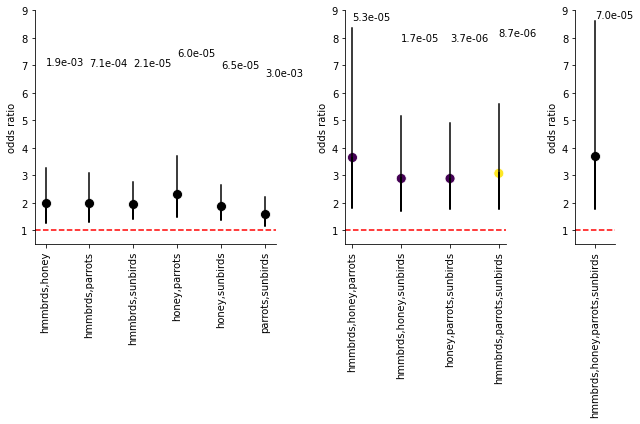

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(9, 6), gridspec_kw={'width_ratios': [6, 4, 1]})
directions = [2, 3, 4]

for i in range(3):
    axi = axes[i]
    d = directions[i]
    dfi = df[(df['count'] == d)]
    sns.scatterplot(ax=axi, data=dfi[dfi['type'] == 'Odds Ratio'], x='pair', y='value',
                    color='black', s=100)
#     axi.set_xticklabels(axi.get_xticklabels(), rotation=5)
    
    
    for p in set(dfi['pair']):
        ci_min = min(dfi[(dfi['pair'] == p)]['value'])
        ci_max = max(dfi[(dfi['pair'] == p)]['value'])
        odds = dfi[(dfi['pair'] == p) & (df['type'] == 'Odds Ratio')]['value']
        ci = dfi[(dfi['pair'] == p) & (df['type'] != 'P-Value')]['value']
        pval = list(dfi[(dfi['pair'] == p) & (df['type'] == 'P-Value')]['value'])[0]
        axi.errorbar(x=p, y=ci, color='black')
       
        ## annotate with p-values
        axi.annotate("{:.1e}".format(pval), (p, odds + 5))
        
    axi.set_ylim(0.5, 9)
    axi.set_ylabel('odds ratio')
    axi.set_xlabel('')
    axi.axhline(y=1, color = "red", linestyle = "dashed")

    axi.tick_params(axis='x', rotation=90)
sns.despine(bottom=False, left=False)
fig.tight_layout()

pdf_name = 'summary_Fexact.convergence.odds_ci_pval.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [41]:
### Compare absrel results v8 VS v58
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/'

versions = ['v8_cinPul', 'v8', 'v58', 'v58_tolerate', 'v58_srv', 'v58_mh', 'v58_srv_mh']
all_results = {}

for v in versions:
    file_name = '{}/all.genes.pval.table.tsv'.format(v)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    pval_tab = pd.read_csv(file_data, sep='\t')
    all_results[v] = pval_tab

v8_cinPul/all.genes.pval.table.tsv
v8/all.genes.pval.table.tsv
v58/all.genes.pval.table.tsv
v58_tolerate/all.genes.pval.table.tsv
v58_srv/all.genes.pval.table.tsv
v58_mh/all.genes.pval.table.tsv
v58_srv_mh/all.genes.pval.table.tsv


In [33]:
# df_merged = pd.merge(pval_tab_1, pval_tab_2, on=['branch', 'trans', 'gene'])
# df_merged.head()

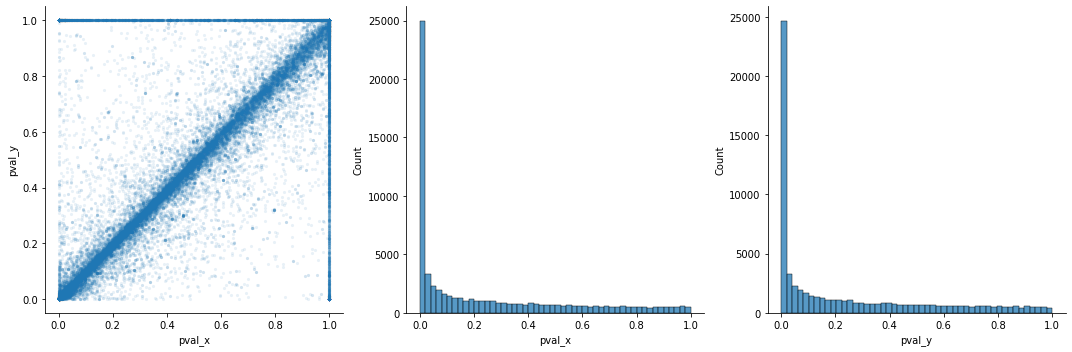

In [82]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# sns.scatterplot(ax=ax1, data=df_merged, x='pval_x', y='pval_y', s=10, alpha=0.1, linewidth=0)
# sns.histplot(ax=ax2, data=df_merged[df_merged['pval_x'] != 1], x='pval_x')
# sns.histplot(ax=ax3, data=df_merged[df_merged['pval_y'] != 1], x='pval_y')


# sns.despine(bottom=False, left=False)
# fig.tight_layout()

# pdf_name = 'summary_Fexact.convergence.odds_ci_pval.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

In [102]:
pval_tab_1['br_trans'] = pval_tab_1['branch'] + ',' + pval_tab_1['trans']
v8 = pval_tab_1[pval_tab_1['pval'] < 0.05]['br_trans'].tolist()

pval_tab_2['br_trans'] = pval_tab_2['branch'] + ',' + pval_tab_2['trans']
v58 = pval_tab_2[pval_tab_2['pval'] < 0.05]['br_trans'].tolist()

print(len(v8))
print(len(v58))

29589
33124


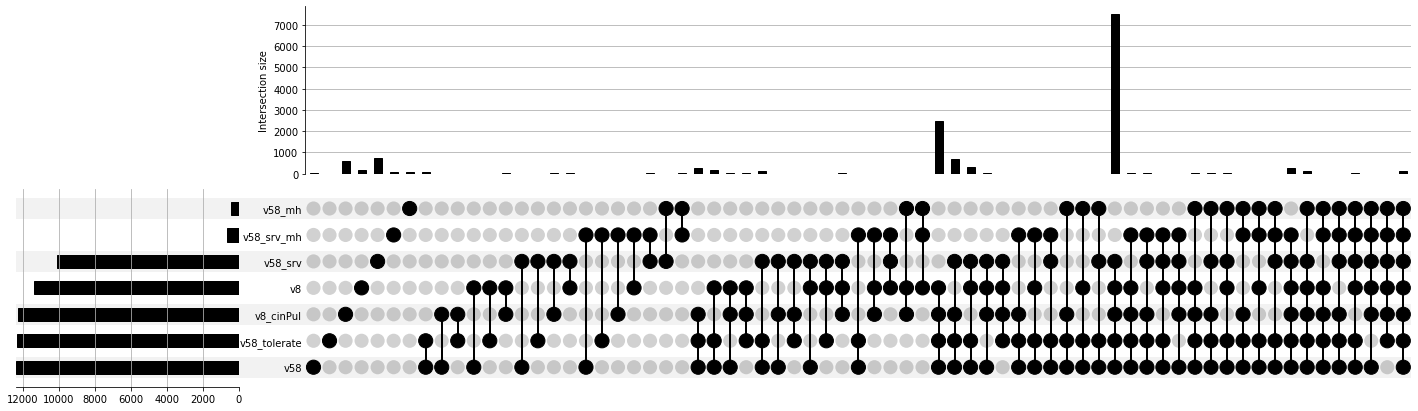

In [47]:
from upsetplot import plot

threshold = 0.05
level = 'trans'
# level = 'gene'

set1 = set(all_results['v8_cinPul'][all_results['v8_cinPul']['pval'] < threshold][level])
set2 = set(all_results['v8'][all_results['v8']['pval'] < threshold][level])
set3 = set(all_results['v58'][all_results['v58']['pval'] < threshold][level])
set4 = set(all_results['v58_tolerate'][all_results['v58_tolerate']['pval'] < threshold][level])
set5 = set(all_results['v58_srv'][all_results['v58_srv']['pval'] < threshold][level])
set6 = set(all_results['v58_mh'][all_results['v58_mh']['pval'] < threshold][level])
set7 = set(all_results['v58_srv_mh'][all_results['v58_srv_mh']['pval'] < threshold][level])
# set4 = set(all_results['combined_default_srv_mh'][all_results['combined_default_srv_mh']['pval'] < threshold][level])


all_elems = set1.union(set2).union(set3).union(set4).union(set5).union(set6).union(set7)
df = pd.DataFrame([[e in set1, 
                    e in set2, 
                    e in set3, 
                    e in set4,
                    e in set5, 
                    e in set6, 
                    e in set7,] for e in all_elems], columns = versions)
df_up = df.groupby(versions).size()

fig = plt.figure(figsize=(25, 7))
plot(df_up, fig=fig, orientation='horizontal', element_size=None, totals_plot_elements=14)


dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/'
# plt.savefig("{}{}.v8_v58_v58_srv_combined.upsetplot.pdf".format(dir_path, level))